# 03- Ensembles
** APSTA - LEARN - Ecole Centrale Nantes **

** Diana Mateus **

PARTICIPANTS: **Chaitanya Krishna VIRIYALA**

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

## 1. Decision stumps
A decision stump is a machine learning model consisting of a one-level decision tree. That is, it is a decision tree with one internal node (the root) which is immediately connected to the terminal nodes (its leaves). A decision stump makes a prediction based on the value of just a single input feature. Sometimes they are also called 1-rules [Wikipedia]

***a)*** Run the provided code to generate and plot a toy dataset consisting of 2D points and 4 classes



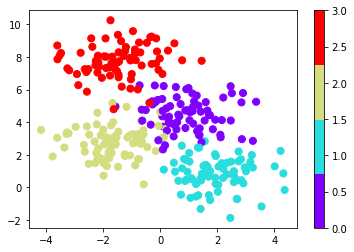

In [22]:
#a) Load and plot dataset, split in train and test sets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

n_classes = 4
X, y = make_blobs(n_samples=300, centers=n_classes,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.get_cmap('rainbow', 4));
plt.colorbar();

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)




**b)** Implement a function that generates a random linear axis-aligned ***stump*** according to the number of features of a given dataset. The function should return 
    - the index of one randomly chosen features (dimension) 
    - as well as a randomly chosen threshold within the min and max values of the chosen feature.
``` python
def stump(Xtrain):
```
**c)**  Make a function **split** that 
    - receives as input the parameters generated by the stump function above. 
    - Partitions the **training** dataset in two subsets.
The output should be two arrays, each containing the _indices_ of the points belonging to one or the other subset. To verify the implementation, run the split function several times, and display the resulting subsets as 2D pointsets with different colors.
``` python
def split(Xtrain, feature, threshold):
```
**d)** Implement a function ***leaf*** that computes and returns the class distribution (normalized histogram #points vs classes) 
    - of the original training set (before the split), 
    - for each of the 2 subsets resulting from after the split has been applied.

``` python
def split_distributions(ytrain,ind_left, ind_right):
```
**e)** Using the output of **split_distributions** Create a function ***information_gain*** that receives the full training dataset (Xtrain and ytrain) and the indices of two subsets resulting from the current split. Use the **entropy** to compute the information gain.
``` python
def information_gain(ytrain,ind_left, ind_right):
```
```Hints: ``` 
- a detailed example is given here: http://www.bogotobogo.com/python/scikit-learn/scikt_machine_learning_Decision_Tree_Learning_Informatioin_Gain_IG_Impurity_Entropy_Gini_Classification_Error.php
- when computing the Entropy, ignore the classes with zero probabilities, and carry on summation using the same equation.





**f)** Create a function ***train*** that receives as parameters the full training dataset (Xtrain and ytrain) as well as the number of random stumps to try. The function will 
- generate the desired number of stumps, 
- split the dataset according to each stump, 
- evaluate the ***information gain*** for each split
- choose and then return the parameters of the best stump.

``` python
def train_stumps(Xtrain, ytrain, trials):
```

**g)** train an ensemble of stumps, average the prediction results and then print the performance (accuracy)



In [23]:
from random import randint, uniform

# b) Stumps

def stump(xx):
    f =  randint(0,1) # randomly select a feature/dimension randint()
    t =  uniform(min(xx[:,f]),max(xx[:,f])) # sample from an uniform() between the min and max values of the feature
    return f,t 

# c) Split

def split(xx, f, t):
    ind_l, = np.where(xx[:,f]<=t) # points going to the left child
    ind_r, = np.where(xx[:,f]>t) # points going to the right child
    return ind_l, ind_r # return indices


# d) Leaf probabilities
def class_distribution(yy, n_classes):
    proba,bin_edges = np.histogram(yy,n_classes,density=True)
    return proba, bin_edges
    
def split_distributions(yy, ind_l, ind_r, n_classes):
    proba_l = class_distribution(yy[ind_l],n_classes)[0]
    proba_r = class_distribution(yy[ind_r],n_classes)[0]
    proba,bin_edges = class_distribution(yy,n_classes)
    
    return proba, proba_l, proba_r, bin_edges


# e) information gain 
def entropy(p):
    p = [i for i in p if i!=0]
    ent = -np.sum(p*np.log2(p))
    return ent

def information_gain(yy, ind_l, ind_r, n_clasess):
    proba, proba_l, proba_r, bin_edges = split_distributions(yy, ind_l, ind_r, n_classes)
    Ir = entropy(proba_r)
    Il = entropy(proba_l)
    I = entropy(proba)
    n = np.size(yy)
    
    info_gain = I - Il*np.size(ind_l)/n -Ir*np.size(ind_r)/n
    
    return info_gain




Stump parameters 0 -3.42322335426019
Sizes of (original set, left subset, right subset)) 225 (7,) (218,)
Info Gain 0.19145650168250983


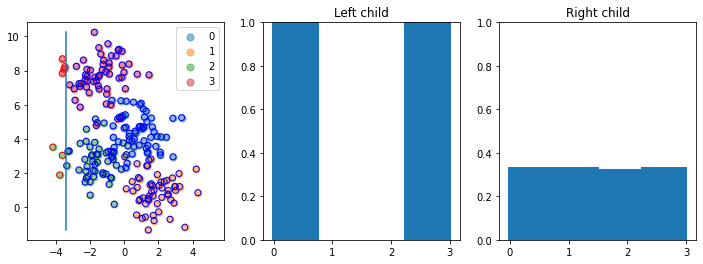

In [24]:
#-------Runing functions from a, e-------------


feat, th = stump(Xtrain)
print('Stump parameters', feat, th)
ind_l,ind_r = split(Xtrain, feat, th)
print('Sizes of (original set, left subset, right subset))', len(ytrain), ind_l.shape, ind_r.shape)

#Compute the information gain based measures
p, p_l, p_r, bins = split_distributions(ytrain, ind_l, ind_r, n_classes)
print('Info Gain', information_gain(ytrain,ind_l, ind_r, n_classes))

#-------Plotting functions-------------
fig, ax = plt.subplots(1,3,figsize=(12, 4))

#Plot the training points with their ground truth class
for c in range(n_classes):
    X0_c=Xtrain[np.where(ytrain==c), 0]
    X1_c=Xtrain[np.where(ytrain==c), 1]
    y_c=c*np.ones(np.shape(Xtrain[np.where(ytrain==c),0]))
    ax[0].scatter(X0_c,X1_c, s=50,alpha=0.5,cmap=plt.cm.get_cmap('rainbow', 4),label=str(c))

ax[0].axis('equal')

#draw the separation of the points by drawing a circle around the original point sets
ax[0].scatter(Xtrain[ind_l, 0], Xtrain[ind_l, 1], c='none', edgecolor='r')
ax[0].scatter(Xtrain[ind_r, 0], Xtrain[ind_r, 1], c='none', edgecolor='b')

#draw a threshold line
if feat == 0:
    ax[0].plot([th,th],[np.min(Xtrain[:,1]),np.max(Xtrain[:,1])])
elif feat == 1:
    ax[0].plot([np.min(Xtrain[:,0]),np.max(Xtrain[:,0])],[th,th])
leg = ax[0].legend();

# Show the histograms over the classes for each subset
center = (bins[:-1] + bins[1:]) / 2
ax[1].bar(center, p_l, align='center')
ax[1].set_ylim((0, 1.0))
ax[1].set_title('Left child')
ax[2].bar(center, p_r, align='center')
ax[2].set_ylim((0, 1.0))
ax[2].set_title('Right child')

plt.show()


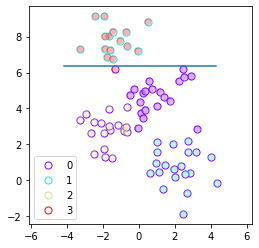

In [25]:
from sklearn import metrics

#f) train a stump
def train_stump(Xtrain, ytrain, trials):
    gains = np.zeros(trials)
    tabt = np.zeros(trials)
    tabf = np.zeros(trials)
    for k in range(trials):
        f,t= stump(Xtrain)
        tabt[k] = t
        tabf[k] = f
        ind_l, ind_r = split(Xtrain, f, t)
        proba, proba_l, proba_r, bin_edges = split_distributions(ytrain, ind_l, ind_r, 4)
        gains[k] = information_gain(ytrain, ind_l, ind_r, 4)
    maxt = tabt[np.where(gains==np.max(gains))[0]][0]
    maxf = tabf[np.where(gains==np.max(gains))[0]][0]
    return maxt,maxf
        
def test_stump(Xtest, f, t, p_l, p_r): 
    ind_l,ind_r = split(Xtest,f,t)
    ypred = np.zeros(len(Xtest))
    ypred[ind_r]=True
    return(ypred)
    
#---------------Run the functions------------------

th,feat = train_stump(Xtrain,ytrain,100)
y_pred = test_stump(Xtest, int(feat), th, p_l, p_l)

#---------------Plot results ------------------

#Plot the ground thruth classes vs predictions
fig, ax = plt.subplots(figsize=(4, 4))

colors = np.random.random((len(ytest), 3))
cmap=plt.cm.get_cmap('rainbow', n_classes)

#draw predictions    
for c in range(n_classes):
    ind = np.where(y_pred==c)
    X0_c=Xtest[ind, 0]
    X1_c=Xtest[ind, 1]
    y_c=c*np.ones([len(ind),0])
    color = cmap(c)
    ax.scatter(X0_c,X1_c, c='w',s=50,edgecolors=color,label=str(c))

#draw ground truth
ax.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=50, edgecolors='none', cmap=plt.cm.get_cmap('rainbow', 4),alpha=0.3);

#draw threshold line
if feat == 0:
    ax.plot([th,th],[np.min(Xtrain[:,1]),np.max(Xtrain[:,1])])
elif feat == 1:
    ax.plot([np.min(Xtrain[:,0]),np.max(Xtrain[:,0])],[th,th])

ax.axis('equal')
leg = ax.legend();

plt.show()



Accuracy:  0.9866666666666667


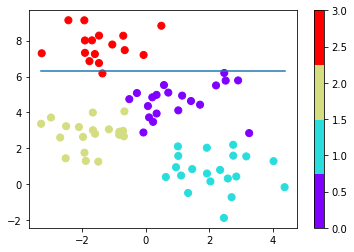

In [26]:
#g) train a series of stumps, average the results and then print the performance (accuracy)
from sklearn.metrics import accuracy_score

th = np.mean([train_stump(Xtrain,ytrain,1000)[0] for k in range(10)]) # the max of gain if always for the second feature

plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=50, cmap=plt.cm.get_cmap('rainbow', 4));
plt.plot([np.min(Xtest[:,0]),np.max(Xtest[:,0])],[th,th])
plt.colorbar();

ypred = np.zeros(ytest.size)

ind_l,ind_r = split(Xtest,1,th)

ypred[ind_r]=True

print('Accuracy: ',accuracy_score(ytest==3,ypred))


**We train our training set. As a preliminary, we notice that it is always on the second dimension that the gain is maximum. It is therefore in relation to him that we threshold. This threshold makes it possible to discriminate the elements of class 3 from others. We take the average of the thresholds obtained and by testing this threshold on our test set, we obtain an *accuracy* very close to 1.**

## 2. Decision Trees

Random forests are an example of an *ensemble learner* built on decision trees. Decision trees are very intuitive:  ask a sequence of binary questions (stumps) to hierarchicaly split data points in different groups. The binary splitting makes the training and testing extremely efficient. The difficulty lies in choosing the *right questions* to ask. Is common to use a randomized optimization algorithm to explore different features and decide which questions (or "splits") provide the most information. The result is a very fast **non-parametric** classification. 

Use the provided code based IPython's ``interact`` and some functions from **fig_code** folder to visualize a decision tree in action and answer to the questions

**a) Visualizing a decision tree**. Increase the depth and observe:
- How are decision trees linked to the stumps trained above?
- In which regions do new splits appear?
- What happens with the splits as depth increases?

**b)** Split the dataset in half and fit a decision tree to each half and visualize.
- Describe the differences in the classification obtained with the two trees
- What does this tell you about the bias and variance of the classifier?
- When is this behaviour problematic? (Explain)

**c) Bootstraping ** sample 100 subsets from the original dataset and give each to a different tree to train. Average and show the results for the full test set



In [27]:
#2. a) Visualizing a decision tree

import fig_code

from fig_code import visualize_tree, plot_tree_interactive
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', options=(1, 5), value=1), Output()), _dom_classes=('widget…

**The nodes of the decision trees correspond to decision stumps. Separations appear where the class of the point group changes. The more the depth increases, the greater the number of separations. Thus, with a tree that is too deep, there is a risk of overfitting.**

<Figure size 432x288 with 0 Axes>

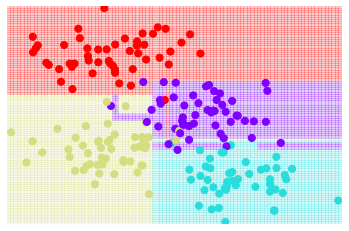

<Figure size 432x288 with 0 Axes>

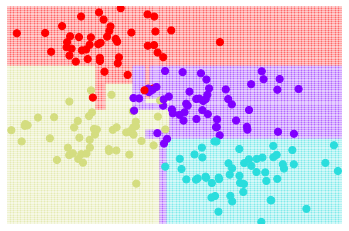

In [28]:
# 2.b)  Subset 
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

plt.figure()
visualize_tree(clf, X[:200], y[:200], boundaries=False)
plt.figure()
visualize_tree(clf, X[-200:], y[-200:], boundaries=False)

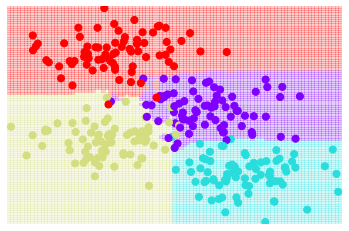

In [29]:
# 2.c)  Subset 

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_tree(clf, X, y, boundaries=False);

## 3. Random Forest for Classifying Digits (or Caltech 101)

We will apply a Random Forest classifier to predict the classes of the **hand-written digits** dataset.

**a)** Run the code to load and visualize the dataset

**b)** Run the code to perform classification with a single decision tree

**c)** Repeat the classification of the dataset
- using a ``sklearn.ensemble.RandomForestClassifier``.  
- How does the ``max_depth``, ``max_features``, and ``n_estimators`` affect the results? 
( Check and print the accuracy and F1 scores for different values of these parameters) 

**d)** Do a gridsearch with crossvalidation varying the three parameters above. 
- What are the best parameters to use for F1 score?
- What's the best F1 score you can reach in the test set?

**e)** Recover the probabilistic predictions of the best models on the test set and plot the ROC curve for the microaveraged predictions https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Size of Data matrix (1797, 64)
Size of target vector (1797,)


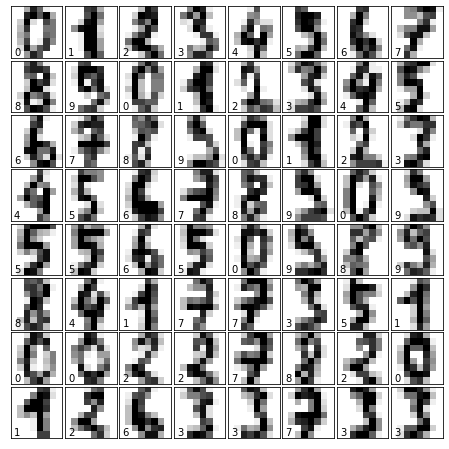

In [30]:
#3.a) Load and visualize dataset
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()
X = digits.data
y = digits.target
print('Size of Data matrix', X.shape)
print('Size of target vector', y.shape)

# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

0.8377777777777777


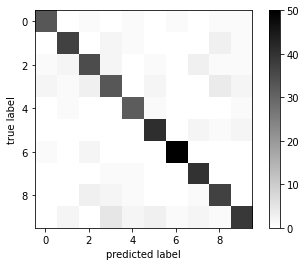

In [31]:
#3.b) Multiclass classification with a decision tree
from sklearn.model_selection import train_test_split
from sklearn import metrics


Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(max_depth=11)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

#performance measure
print(metrics.accuracy_score(ypred, ytest))

#confusion matrix
plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("predicted label")
plt.ylabel("true label");

0.98


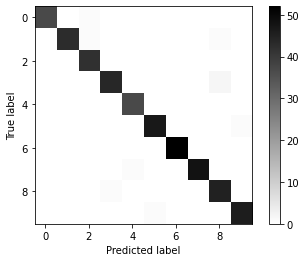

In [32]:
#3.c) Classification with a Random Forest

from sklearn.ensemble import RandomForestClassifier

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = RandomForestClassifier(max_depth=11)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
print(metrics.accuracy_score(ypred, ytest))

plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label");



In [33]:
# 3. d) Grid search cross-validation
#uncomment according to version
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV


target_names = ['class 0', 'class 1', 'class 2', 
                'class 3', 'class 4', 'class 5', 
                'class 6', 'class 7', 'class 8', 'class 9']

tuned_parameters = [{'max_depth': [1, 5, 10], 
                     'max_features': [1, 20, 50, 64],
                     'n_estimators': [1, 10, 50, 100]}]

gscv_model = GridSearchCV(RandomForestClassifier(max_depth=5, max_features = 1, n_estimators = 10),
                          cv=5, param_grid = tuned_parameters, scoring='accuracy')
gscv_model.fit(X, y)




GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=5, max_features=1,
                                              n_estimators=10),
             param_grid=[{'max_depth': [1, 5, 10],
                          'max_features': [1, 20, 50, 64],
                          'n_estimators': [1, 10, 50, 100]}],
             scoring='accuracy')

In [20]:
# Print grid search and cross validation results of each parameter set


# Print best parameters and score
print('Best params:', gscv_model.best_params_)
print('Best score:', gscv_model.best_score_)

# Predict on test set 
ypred = gscv_model.predict(Xtest)

# Print compact report on test set
print(metrics.classification_report(ytest, ypred, target_names = target_names))
print(ytest)
print(ypred)

#performance measure
print('Accuracy', metrics.accuracy_score(ypred, ytest))


Best params: {'max_depth': 10, 'max_features': 1, 'n_estimators': 100}
Best score: 0.9310043330238317
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00        37
     class 1       1.00      1.00      1.00        43
     class 2       1.00      1.00      1.00        44
     class 3       1.00      1.00      1.00        45
     class 4       1.00      1.00      1.00        38
     class 5       1.00      1.00      1.00        48
     class 6       1.00      1.00      1.00        52
     class 7       1.00      1.00      1.00        48
     class 8       1.00      1.00      1.00        48
     class 9       1.00      1.00      1.00        47

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

[2 8 2 6 6 7 1 9 8 5 2 8 6 6 6 6 1 0 5 8 8 7 8 4 7 5 4 9 2 9 4 7 6 8 9 4 3
 1 0 1 8 6 7 7 1 0 7 6 2 1 9 6 7 9 0 0 5 1 6 3 0 2 3 4 1 9 2 6 9

### Answer to questions:
**We note that:**
- When we increase the maximum depth (max_depth) we decrease the precision
- The max_feautures does not affect the precision much
- The n_estimators affect the precision more than the max_features
#### We also notice that the influence of these parameters remains small to change the result.